<a href="https://colab.research.google.com/github/bhanuprakash-molli/SB4C_AICTE_Batch_4_G3/blob/main/imdb_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import cohen_kappa_score

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

from imblearn.over_sampling import SMOTE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

IMDB **DataSet**

In [3]:
data=pd.read_csv("/content/data.csv")

In [ ]:
data.head(10)

,review,label
0,this was painful i made myself watch it until ...,0.0
1,once again mr costner has dragged out a movie ...,0.0
2,by strange coincidence i ve started to watch t...,0.0
3,well the hero and the terror is slightly below...,0.0
4,well the hero and the terror is slightly below...,0.0
5,this is an example of why the majority of acti...,0.0
6,the creators of this movie must have sat down ...,0.0
7,cultural vandalism is the new hallmark product...,0.0
8,first of all i hate those moronic rappers who ...,0.0
9,this adaption contains two parts br br 1 the n...,0.0


In [4]:
data.isnull().sum()

review    2
label     5
dtype: int64

In [5]:
data=data.dropna().reset_index(drop=True)

In [6]:
data.isnull().sum()

review    0
label     0
dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size = .4, shuffle = False)

In [8]:
len(X_train), len(y_train), len(X_test), len(y_test)

(29446, 29446, 19632, 19632)

In [9]:
sentiments = data['label'].value_counts()
print('Sentiments in entire dataset:\n Positive: {}\n Negative: {}'.format(sentiments[1], sentiments[0]))

Sentiments in entire dataset:
 Positive: 24536
 Negative: 24542


In [10]:
def get_sentiments(d, _d):
    positive = (d==1).sum()
    negative = (d==0).sum()
    print('Sentiments in {}:\n Positive: {}\n Negative: {}'.format(_d, positive, negative))

In [11]:
get_sentiments(y_train, 'Train data')
get_sentiments(y_test, 'Test data')

Sentiments in Train data:
 Positive: 12333
 Negative: 17113
Sentiments in Test data:
 Positive: 12203
 Negative: 7429


In [12]:
def tokenize(text):
    return [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]

In [13]:
def choose_vectorizer(option):
    if option == 'generate':
        vectorizer = TfidfVectorizer(tokenizer = tokenize)
    elif option == 'load':
        vectorizer = TfidfVectorizer(vocabulary = pickle.load(open('vocabulary.pkl', 'rb')))

    return vectorizer

In [16]:
%%time
options = ['generate', 'load']

# 0 to generate, 1 to load (choose wisely, your life depends on it!)
option = options[1]

vectorizer = choose_vectorizer(option)
vectorized_train_data = vectorizer.fit_transform(X_train)
vectorized_test_data = vectorizer.transform(X_test)

if option == 'generate':
    pickle.dump(vectorizer.vocabulary_, open('vocabulary.pkl', 'wb'))

CPU times: user 13.7 s, sys: 217 ms, total: 13.9 s
Wall time: 19 s


In [17]:
%%time
sm = SMOTE(random_state=42,sampling_strategy='auto')
X_train, y_train  = sm.fit_resample(vectorized_train_data, y_train)


CPU times: user 41min 51s, sys: 3.04 s, total: 41min 54s
Wall time: 25min 3s


In [19]:
clf=LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [20]:
kf = KFold(n_splits=10, random_state = 42, shuffle = True)
scores = cross_val_score(clf, X_train, y_train, cv = kf)

In [21]:
print('Cross-validation scores:', scores)
print('Cross-validation accuracy: {:.4f} (+/- {:.4f})'.format(scores.mean(), scores.std() * 2))


Cross-validation scores: [0.90972831 0.90972831 0.91264972 0.91206544 0.90359334 0.90914403
 0.90298071 0.92226768 0.91350088 0.9181765 ]
Cross-validation accuracy: 0.9114 (+/- 0.0112)


In [22]:
predictions = clf.predict(vectorized_test_data)

validation = dict()

validation['accuracy'] = accuracy_score(y_test, predictions)
validation['precision'] = precision_score(y_test, predictions, average='macro')
validation['recall'] = recall_score(y_test, predictions, average='macro')
validation['f1'] = f1_score(y_test, predictions, average='macro')

In [23]:
print('Validation results:\n', '-' * 12)
for v in validation:
    print('{}: {:.5f}'.format(v.title(), validation[v]))

Validation results:
 ------------
Accuracy: 0.86975
Precision: 0.85951
Recall: 0.87251
F1: 0.86428


In [24]:
p = predictions.tolist()
ck = cohen_kappa_score(y_test, p)
print('C-K Score: {:.5f}'.format(ck))


C-K Score: 0.72906


In [25]:
example_reviews = [
    'An honest, engaging, and surprisingly funny look back at one of modern television\'s greatest achievements.',
    'Excellent movie! Inspiring and very entertaining for all especially youth and anyone inspired by today\'s modern age of tech entrepreneurship!',
    'Honestly even the trailer made me uncomfortable.',
    'I never write movie reviews, but this one was such a stinker, I feel I owe it to everyone to at least provide a warning.',
    'This movie was a good movie by standard and a lil beyond standard. It was written very well, The acting was great, each characters performance was clever and the comedic timing was spot on. The story line is very real and relatable. Enjoyable for adults and completely appropriate for pre-teens up to 20. Go support, my family loved it.'
]

In [26]:
example_preds = clf.predict(vectorizer.transform(example_reviews))
print(' '.join(str(int(p)) for p in example_preds))

1 1 0 0 1


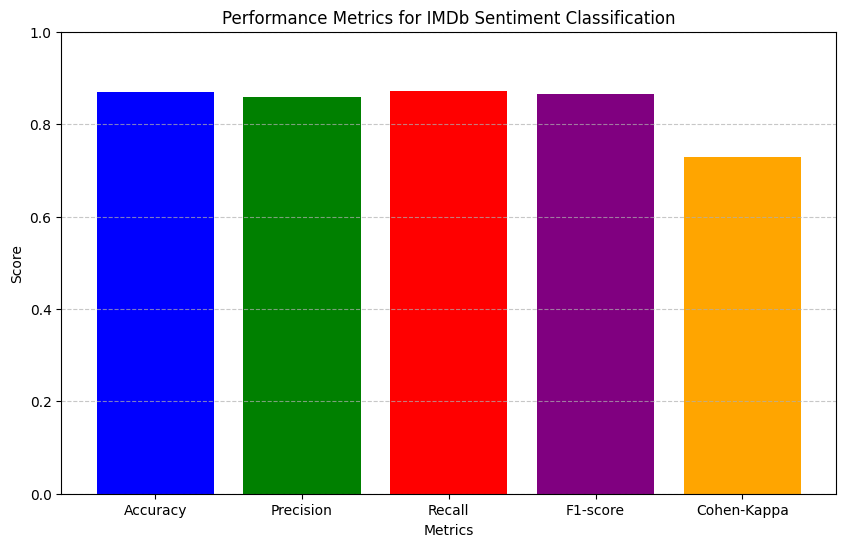

In [27]:
import matplotlib.pyplot as plt

# Define performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Cohen-Kappa']
scores = [validation['accuracy'], validation['precision'], validation['recall'], validation['f1'], ck]

# Plot performance metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title('Performance Metrics for IMDb Sentiment Classification')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


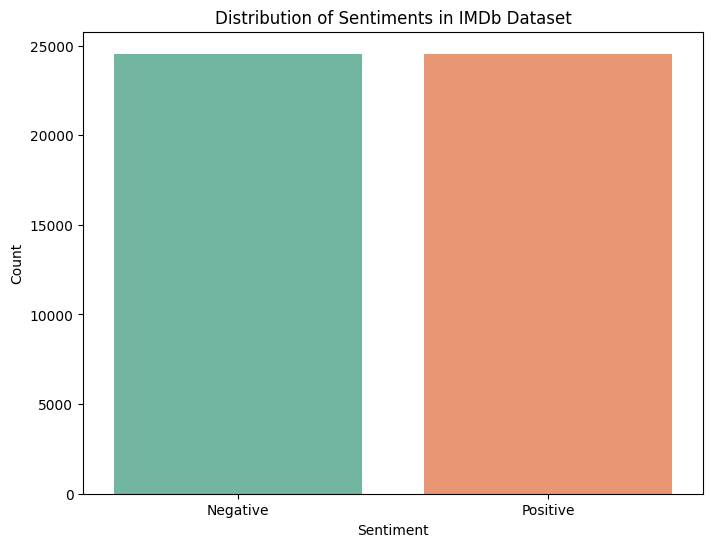

In [28]:
import seaborn as sns

# Count the number of positive and negative sentiments in the dataset
sentiment_counts = data['label'].value_counts()

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data, palette='Set2')
plt.title('Distribution of Sentiments in IMDb Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()


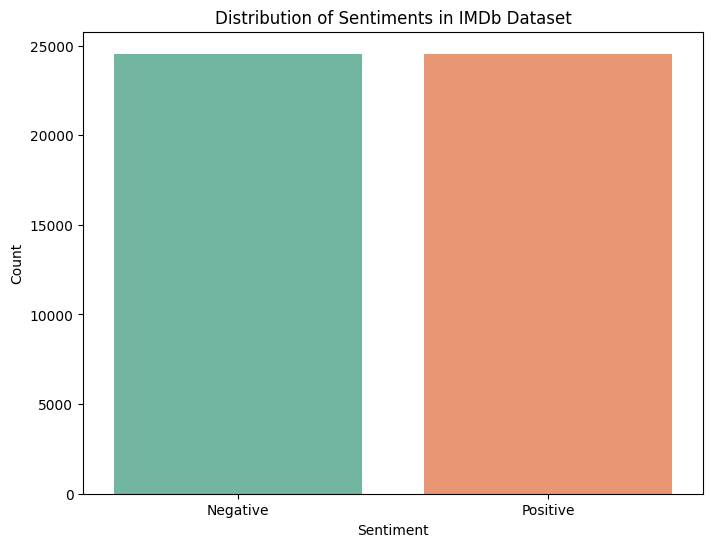

In [29]:
import seaborn as sns

# Count the number of positive and negative sentiments in the dataset
sentiment_counts = data['label'].value_counts()

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data, palette='Set2')
plt.title('Distribution of Sentiments in IMDb Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()


In [ ]:
import seaborn as sns

# Plot sentiment distribution with hue
plt.figure(figsize=(8, 6))
sns.countplot(x='label', hue='review', data=data, palette='Set2')
plt.title('Distribution of Sentiments in IMDb Dataset with Hue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.legend(title='Some Variable')
plt.show()
